In [2]:
import kwant
import scipy
import numpy as np
from scipy.linalg import block_diag

from types import SimpleNamespace

import Modules.pauli as pauli
import Modules.TB_parameters as Tpar
import Modules.ribbon_params_11_band as rp
import Modules.Ham_MX2_11_band as Ham
import Modules.functions as func
import Modules.plot_functions as pf

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('axes', linewidth=1.5)

# Lattice sketches

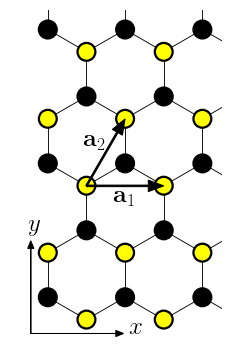

In [4]:
def hex_sheet(x1, x2, y1, y2):
    norbs = [1, 1]
    MX2 = kwant.lattice.general([(1, 0), (-1/2, np.sqrt(3)/2)],  # Bravais lattice vectors a1 and a2
                                [(0, 0), (1/2, 1/(2*np.sqrt(3)))], # Atom coordinates in a unit cell, M and X
                                norbs=norbs) # Number of orbitals per atom type, M and X 
    M, X = MX2.sublattices
    

    def square(site):
        x, y = site.pos
        return (x1 <= x < x2) and (y1 <= y < y2)

    # Make a builder for a 2D system with a minimal unit cell.
    bulk_sym = kwant.TranslationalSymmetry(MX2.vec((1, 0)), MX2.vec((0, 1)))   # For 2D bulk trans inv
    bulk = kwant.Builder(bulk_sym)
    
    # Onsites
    bulk[[M(0, 0)]] = 1
    bulk[[X(0, 0)]] = 1
    
    bulk[MX2.neighbors()] = 1

    syst = kwant.Builder()
    added_sites = syst.fill(bulk, square,
                            (x1, y1), max_sites=float('inf'))
    
    def family_colors(site):
        # red, green, blue, transparency
        return 'black' if site.family != M else 'yellow'

    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(1, 1, 1)
    kwant.plot(syst, ax=ax1, site_color=family_colors, site_size=0.20, site_lw=0.05, hop_lw=0.02,
               colorbar=False);
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    ax1.arrow(0.28, -0.18, 0.0, 1.1, head_width=0.08, head_length=0.1, fc='k',
              ec='k', zorder=1)
    ax1.text(0.24, 1.15, r'$y$', fontsize=25)
    ax1.arrow(0.28, -0.18, 1.1, 0.0, head_width=0.08, head_length=0.1,
              fc='k', ec='k', zorder=1)
    ax1.text(1.55, -0.18, r'$x$', fontsize=25)
    
    ax1.arrow(1.0, 1.73, 0.8, 0.0, width=0.02, head_width=0.15, head_length=0.2,
              fc='k', ec='k', zorder=2)
    ax1.text(1.35, 1.47, r'${\bf a}_1$', fontsize=25)
    ax1.arrow(1.0, 1.73, 0.4, 0.693, width=0.02, head_width=0.15, head_length=0.2,
              fc='k', ec='k', zorder=2)
    ax1.text(0.95, 2.2, r'${\bf a}_2$', fontsize=25)
    
    ax1.set_xlim(0.23, 2.75)
    ax1.set_ylim(-0.22, 4)
    plt.savefig('hex_sheet.pdf', bbox_inches='tight')
    

x1 = 0.4
x2 = 4
y1 = 0
y2 = 6
hex_sheet(x1, x2, y1, y2)

In [5]:
def lattice_2D(x1, x2, y1, y2):
    norbs = [1, 1]
    MX2 = kwant.lattice.general([(1, 0), (-1/2, np.sqrt(3)/2)],  # Bravais lattice vectors a1 and a2
                                [(0, 0), (1/2, 1/(2*np.sqrt(3)))], # Atom coordinates in a unit cell, M and X
                                norbs=norbs) # Number of orbitals per atom type, M and X 
    M, X = MX2.sublattices
    

    def square(site):
        x, y = site.pos
        return (x1 <= x < x2) and (y1 <= y < y2)

    # Make a builder for a 2D system with a minimal unit cell.
    bulk_sym = kwant.TranslationalSymmetry(MX2.vec((1, 0)), MX2.vec((0, 1)))   # For 2D bulk trans inv
    bulk = kwant.Builder(bulk_sym)
    
    # Onsites
    bulk[[M(0, 0)]] = 1
    bulk[[X(0, 0)]] = 1
    
    bulk[MX2.neighbors()] = 1

    syst = kwant.Builder()
    added_sites = syst.fill(bulk, square,
                            (x1, y1), max_sites=float('inf'))
    
    def family_colors(site):
        return 'r' if site.family == M else 'g'
    
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(1, 1, 1)
    kwant.plot(syst, ax=ax1, site_color=family_colors, site_size=0.20, site_lw=0.05, hop_lw=0.02,
               colorbar=False);
    ax1.axis('off')
    ax1.set_aspect('equal')
    ax1.set_xlim(0.25, 1.75)
    ax1.set_ylim(-0.25, 1.4)
    plt.savefig('lattice_2D.pdf', bbox_inches='tight')
    


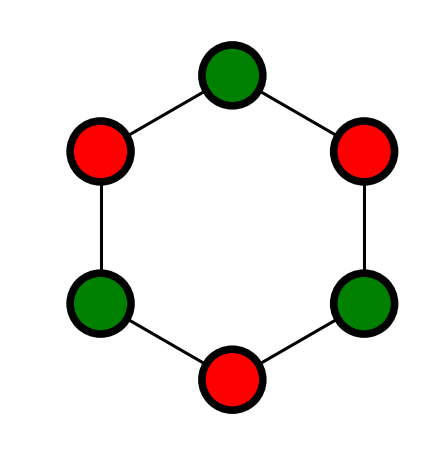

In [6]:
x1 = 0.5
x2 = 2
y1 = 0
y2 = 1.6
lattice_2D(x1, x2, y1, y2)

In [139]:
def lattice_3D(x1, x2, y1, y2):

    
    # Number of orbitals per atom.
    norbs = [1, 1, 1]    # M, XA, XB
    # We use the separation a between identical atoms as the lattice constant.
    # The separation between stacked XA and XB is d.
    d_over_a = Tpar.dxx/Tpar.a
    MX2 = kwant.lattice.general([(1, 0, 0), (-1/2, np.sqrt(3)/2, 0)],      # Bravais lattice vectors a1 and a2
                                [(0, 0, 0),                                # Coordinate of M in unit cell
                                 (1/2, 1/(2*np.sqrt(3)), 0.5*d_over_a),    # Coordinate of X_A
                                 (1/2, 1/(2*np.sqrt(3)), -0.5*d_over_a)],  # Coordinate of X_B
                                norbs=norbs) # Number of orbitals per atom type, M, XA, XB
    M, XA, XB = MX2.sublattices

    def square(site):
        x, y, z = site.pos
        return (x1 <= x < x2) and (y1 <= y < y2)

    # Make a builder for a 2D system with a minimal unit cell.
    bulk_sym = kwant.TranslationalSymmetry(MX2.vec((1, 0)), MX2.vec((0, 1)))   # For 2D bulk trans inv
    bulk = kwant.Builder(bulk_sym)

    # Onsites
    bulk[M(0, 0)] = 1
    bulk[XA(0, 0)] = 1
    bulk[XB(0, 0)] = 1    
    
    bulk[MX2.neighbors()] = 1

    # Plot some hoppings
    ##### M to M, nearest neighbour - unchanged. ######################
    NN_MM_hop_1 = ((1, 0), M, M)
    bulk[[kwant.builder.HoppingKind(*NN_MM_hop_1)]] = 1
    NN_MM_hop_2 = ((1, 1), M, M)
    bulk[[kwant.builder.HoppingKind(*NN_MM_hop_2)]] = 1
    NN_MM_hop_3 = ((0, 1), M, M)
    bulk[[kwant.builder.HoppingKind(*NN_MM_hop_3)]] = 1

    ##### X to X hoppings ####################################
    # XA to XB for stacked atoms, directly above each other.
    XA_to_XB_stacked = ((0, 0), XB, XA)
    bulk[[kwant.builder.HoppingKind(*XA_to_XB_stacked)]] = 1
    
    # Other X to X hoppings from the 2D model.
    # X to X, nearest neighbour
    # Along delta_1 direction.
    NN_XAXA_hop_1 = ((1, 0), XA, XA)
    bulk[[kwant.builder.HoppingKind(*NN_XAXA_hop_1)]] = 1

    NN_XBXB_hop_1 = ((1, 0), XB, XB)
    bulk[[kwant.builder.HoppingKind(*NN_XBXB_hop_1)]] = 1

    # Along delta_2 direction.
    NN_XAXA_hop_2 = ((1, 1), XA, XA)
    bulk[[kwant.builder.HoppingKind(*NN_XAXA_hop_2)]] = 1

    NN_XBXB_hop_2 = ((1, 1), XB, XB)
    bulk[[kwant.builder.HoppingKind(*NN_XBXB_hop_2)]] = 1

    # Along delta_3 direction.
    NN_XAXA_hop_3 = ((0, 1), XA, XA)
    bulk[[kwant.builder.HoppingKind(*NN_XAXA_hop_3)]] = 1
    
    NN_XBXB_hop_3 = ((0, 1), XB, XB)
    bulk[[kwant.builder.HoppingKind(*NN_XBXB_hop_3)]] = 1


    syst = kwant.Builder()
    start = (x1, x2, 0)
    added_sites = syst.fill(bulk, square,
                            start, max_sites=float('inf'))
    
    def family_colors(site):
        # red, green, blue, transparency
        return 'yellow' if site.family != M else 'black'

    def hopping_lw(site1, site2):
        if ((site1.family == XA and site2.family == M) or
            (site1.family == M and site2.family == XA) or
            (site1.family == XB and site2.family == M) or
            (site1.family == M and site2.family == XB) or
            (site1.family == XA and site2.family == XB) or
            (site1.family == XB and site2.family == XA)):
            return 0
        else:
            return 0.01
    
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    kwant.plot(syst, ax=ax1, site_color=family_colors, site_size=0.10, site_lw=0.03, hop_lw=hopping_lw,
               colorbar=False);
    ax1.axis('off')
    ax1.set_aspect('equal')
    ax1.set_xlim(0.65, 1.75)
    ax1.set_ylim(0.8, 1.9)
    ax1.set_zlim(-0.1, 1.0)
    
#     ax1.view_init(elev=20, azim=15)
    ax1.view_init(elev=15, azim=10)
    
    plt.savefig('lattice_3D.pdf', bbox_inches='tight')



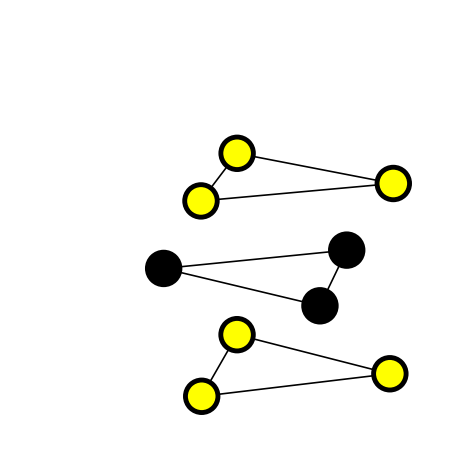

In [140]:
x1 = 0
x2 = 1.5
y1 = 0.5
y2 = 2.5
lattice_3D(x1, x2, y1, y2)

# Sketch of crossings

### Continuum

Using artificial parameters

In [317]:
def get_cont_bands(eta=1):
    def func(kx, ky):
        return energies(kx, ky, eta=eta)
    return func

def get_diff(eta=1):
    def func(kx, ky):
        Es = energies(kx, ky, eta=eta)
        return np.abs(Es[1] - Es[0])
    return func

# Always return spin up first, spin down second
def spin_cont_bands(eta=1):
    def func(kx, ky):
        return spin_energies(kx, ky, eta=eta)
    return func

In [634]:
fs = SimpleNamespace(f0=1.6735, f1=1.1518, f2=0.0744, f3=-0.0613, f4=-0.078, f5=0.0746, f6=-0.0015)

kin = 0.807 # eV
beta_SOI = -0.0015 # eV
A1 = 0.0361 # eV
A2 = -0.00489 # eV

# Use exaggerated SOI to get nice schematics
A2 = -0.7 # eV
beta_SOI = -0.0005 # eV

def H_cond_spinful(kx, ky, eta=1):
    """For a single valley, with SOI, only the spin split conduction band. Momenta are scaled
    in terms of the lattice constant a.
    
    eta = +-1 for K and -K"""

    # Single-valley, spinful, no SC
    H = (kin*(kx**2 + ky**2)*pauli.s0 +
         (eta*beta_SOI + eta*A1*(kx**2 + ky**2) +
          A2*(kx**3 - 3*kx*ky**2))*pauli.sz)
    return H

def energies(kx, ky, eta=1):
    return np.linalg.eigh(H_cond_spinful(kx, ky, eta=eta))[0]

def spin_energies(kx, ky, eta=1):
    """Order energies by spin"""
    evals, evecs = np.linalg.eigh(H_cond_spinful(kx, ky, eta=eta))
    for E, col in zip(evals, evecs.T):
        if np.allclose(col, np.array([1, 0])):
            Eup = E
        else:
            Edown = E
    return Eup, Edown
        

In [635]:
kxs = np.linspace(-0.15, 0.15, 201)
ky = 0
eta = 1
Es = [energies(kx, ky, eta=eta) for kx in kxs]

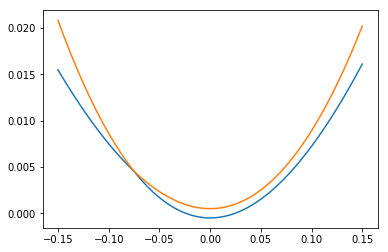

In [636]:
plt.plot(kxs, Es)
# plt.ylim(0.028, 0.045)

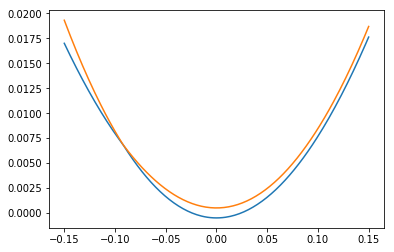

In [586]:
plt.plot(kxs, Es)
# plt.ylim(0.028, 0.045)

In [663]:
kmax = 0.11
N = 200
eta = 1

kxs = np.linspace(-kmax, kmax, N)
kys = np.linspace(-kmax, kmax, N)

x, y = np.meshgrid(kxs, kys)
fvals = evaluate_on_grid(x, y, fun=spin_cont_bands(eta=eta))

In [664]:
Eup = fvals[:, :, 0]
Edown = fvals[:, :, 1]

In [665]:
V = [0.007]
# V = [0.005]

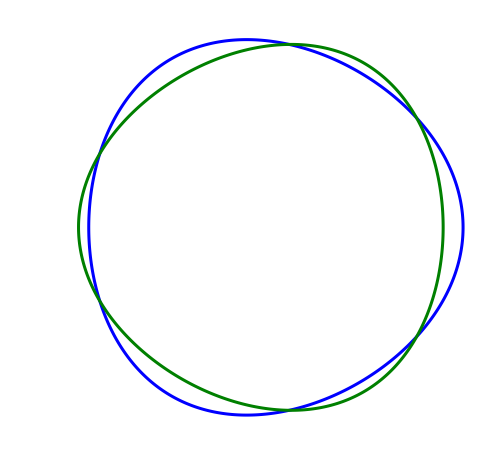

In [666]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.contour(x, y, Eup, V, colors=('b'), linewidths=3)
ax1.contour(x, y, Edown, V, colors=('g'), linewidths=3)
ax1.axis('off')
ax1.set_aspect('equal')
plt.savefig('cross_K.pdf', bbox_inches='tight')

In [667]:
kmax = 0.11
N = 200
eta = -1

kxs = np.linspace(-kmax, kmax, N)
kys = np.linspace(-kmax, kmax, N)

x, y = np.meshgrid(kxs, kys)
fvals = evaluate_on_grid(x, y, fun=spin_cont_bands(eta=eta))

In [668]:
Eup = fvals[:, :, 0]
Edown = fvals[:, :, 1]

In [669]:
V = [0.007]
# V = [0.005]

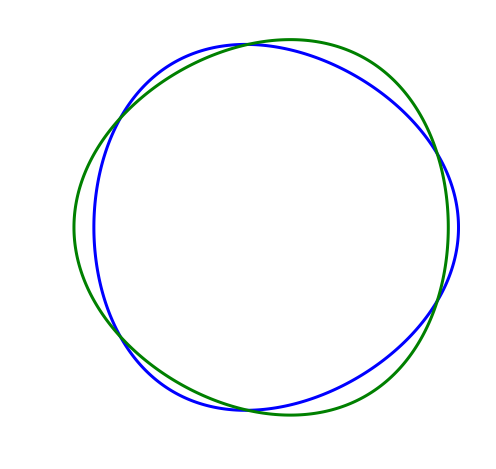

In [670]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax1.contour(x, y, Eup, V, colors=('b'), linewidths=3)
ax1.contour(x, y, Edown, V, colors=('g'), linewidths=3)
ax1.axis('off')
ax1.set_aspect('equal')
plt.savefig('cross_-K.pdf', bbox_inches='tight')

# Sketch the nodal points

In [7]:
def coords(theta, r=1., shift=(0, 0)):
    return r*np.cos(theta) + shift[0], r*np.sin(theta) + shift[1]

def nodal_points(angles, r=1., shift=(0, 0)):
    return zip(*[coords(angle, r=r, shift=shift) for angle in angles])

In [8]:
# Angles of nodal points
theta = np.pi/10
plus_thetas = [theta, theta+2*np.pi/3, theta+4*np.pi/3]
minus_thetas = [-theta, -theta+2*np.pi/3, -theta+4*np.pi/3]

In [9]:
r = .3
shift = np.array([0.6, 0])

pxsR, pysR = nodal_points(plus_thetas, r=r, shift=shift)
mxsR, mysR = nodal_points(minus_thetas, r=r, shift=shift)
pxsL, pysL = nodal_points([-theta + np.pi for theta in plus_thetas], r=r, shift=-shift)
mxsL, mysL = nodal_points([-theta + np.pi for theta in minus_thetas], r=r, shift=-shift)

In [10]:
mysL

(-0.092705098312484177, 0.29344428022014168, -0.20073918190765741)

In [11]:
mysR

(-0.092705098312484219, 0.29344428022014168, -0.20073918190765735)

In [12]:
WxBZ = 2*shift[0]
WyBZ = WxBZ * np.sqrt(3)/2
BZ_corners = [(WxBZ/2, 0), (WxBZ/4, WyBZ/2), (-WxBZ/4, WyBZ/2),
              (-WxBZ/2, 0), (-WxBZ/4, -WyBZ/2), (WxBZ/4, -WyBZ/2),
             (WxBZ/2, 0)]

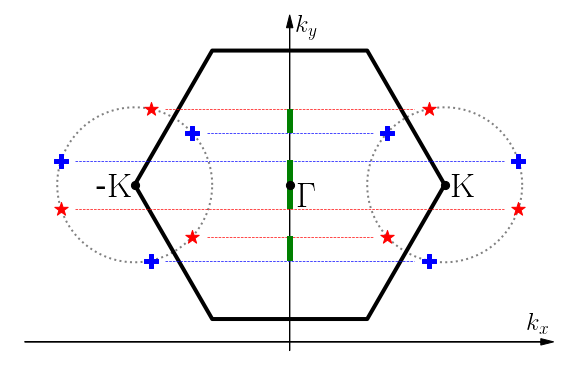

In [13]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

# Nodal points
point_size = 200
ax1.scatter(pxsR, pysR, marker='P', color='b', s=point_size, zorder=4)
ax1.scatter(mxsR, mysR, marker='*', color='r', s=point_size, zorder=4)
ax1.scatter(pxsL, pysL, marker='P', color='b', s=point_size, zorder=4)
ax1.scatter(mxsL, mysL, marker='*', color='r', s=point_size, zorder=4)
corner_xs, corner_ys = zip(*BZ_corners)
ax1.plot(corner_xs, corner_ys, color='black', lw=4)

# Circles where SOI vanishes
circle = [coords(theta, r=r, shift=shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)

xbound = WxBZ/2 * 1.3 + r
ax1.set_xlim(-xbound, xbound)
ybound = WyBZ/2 * 1.3
ax1.set_ylim(-ybound, ybound)

# k_x and k_y axes
ax1.arrow(0, -0.95*ybound, 0.0, 1.85*ybound, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax1.text(0.025, 0.85*ybound, r'$k_y$', fontsize=25)
ax1.arrow(-0.95*xbound, -0.9*ybound, 1.85*xbound, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax1.text(0.85*xbound, -0.85*ybound, r'$k_x$', fontsize=25)

# Gamma, K, -K
symmetry_points = [(0, 0), (WxBZ/2, 0), (-WxBZ/2, 0)]
for point in symmetry_points:
    ax1.scatter(point[0], point[1], color='k', s=point_size/3, zorder=4)
ax1.text(0.03, -0.085, r'$\Gamma$', fontsize=35)
ax1.text(WxBZ/2+0.025, -0.05, r'$\mathrm{K}$', fontsize=35)
ax1.text(-WxBZ/2-0.15, -0.05, r'-$\mathrm{K}$', fontsize=35)

# Lines projecting onto k_y
y_coords = list(mysL) + list(pysL)
x_extents = list(zip(mxsL, mxsR)) + list(zip(pxsL, pxsR))
eps = 0.055
for y, (x_L, x_R) in zip(y_coords, x_extents):
    if any(np.isclose(y, mysL)):
        ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=0.7, color='red', zorder=2)
    else:
        ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=0.7, color='blue', zorder=2)

# Boundaries of topological regions along y
# Pairs of y-coordinates - topo between each pair.
boundaries = list(zip(np.sort(mysL), np.sort(pysL)))
delta = 0.01
for boundary in boundaries:
    lower, upper = np.sort(boundary)
    ax1.plot([0, 0], [lower+delta, upper-delta], color='g', lw=6, zorder=3)

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off');

plt.savefig('nodal_BZ_sketch.pdf', bbox_inches='tight')

## Circles at the K point, both regimes

In [14]:
def get_thetas(theta):
    # plus thetas, minus thetas
    return [theta, theta+2*np.pi/3, theta+4*np.pi/3], [-theta, -theta+2*np.pi/3, -theta+4*np.pi/3]

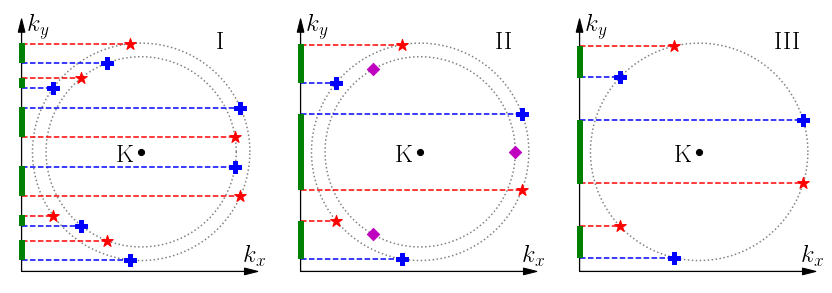

In [15]:
# Circle radius
r1 = 0.4
r2 = 0.35

fig = plt.figure(figsize=(15, 5))

### Subfigure 1
ax1 = fig.add_subplot(1, 3, 1)

# Circle 1 nodal points
theta1 = np.pi/12 + 0.05*np.pi
plus_thetas, minus_thetas = get_thetas(theta1)
pxs1, pys1 = nodal_points(plus_thetas, r=r1)
mxs1, mys1 = nodal_points(minus_thetas, r=r1)

# Circle 2 nodal points
theta2 = np.pi/20
plus_thetas, minus_thetas = get_thetas(theta2)
mxs2, mys2 = nodal_points(plus_thetas, r=r2)
pxs2, pys2 = nodal_points(minus_thetas, r=r2)

# Nodal points
point_size = 150
ax1.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
ax1.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
ax1.scatter(pxs2, pys2, marker=r'P', color='b', s=point_size, zorder=4)
ax1.scatter(mxs2, mys2, marker=r'*', color='r', s=point_size, zorder=4)

# Lines projecting onto k_y
y_coords = list(mys1) + list(pys1) + list(mys2) + list(pys2)
x_coords = list(mxs1) + list(pxs1) + list(mxs2) + list(pxs2)
eps = 0.0
for y, x in zip(y_coords, x_coords):
    x_L = -1.1*r1
    x_R = x
    if any(np.isclose(y, list(mys1) + list(mys2))):
        ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
    else:
        ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)
        
# Boundaries of topological regions along y
# Pairs of y-coordinates - topo between each pair.
boundaries = list(zip(np.sort(list(mys1) + list(mys2)),
                      np.sort(list(pys1) + list(pys2))))
delta = 0.01
for boundary in boundaries:
    lower, upper = np.sort(boundary)
    ax1.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)

# Circles where SOI vanishes
circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
cxs1, cys1 = zip(*circle1)
ax1.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)
circle2 = [coords(theta, r=r2) for theta in np.linspace(0, 2*np.pi, 201)]
cxs2, cys2 = zip(*circle2)
ax1.plot(cxs2, cys2, linestyle='dotted', color='grey', lw=1.5, zorder=1)


### Subfigure 2
ax2 = fig.add_subplot(1, 3, 2)

# Circle 1 nodal points
theta1 = np.pi/12 + 0.03*np.pi
plus_thetas, minus_thetas = get_thetas(theta1)
pxs1, pys1 = nodal_points(plus_thetas, r=r1)
mxs1, mys1 = nodal_points(minus_thetas, r=r1)

# Circle 2 nodal points
theta2 = 0
plus_thetas, minus_thetas = get_thetas(theta2)
pxs2, pys2 = nodal_points(plus_thetas, r=r2)
# mxs2, mys2 = nodal_points(minus_thetas, r=r2)

# Nodal points
ax2.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
ax2.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
ax2.scatter(pxs2, pys2, marker=r'D', color='m', s=point_size/2, zorder=4)

# Lines projecting onto k_y
y_coords = list(mys1) + list(pys1)
x_coords = list(mxs1) + list(pxs1)
eps = 0.0
for y, x in zip(y_coords, x_coords):
    x_L = -1.1*r1
    x_R = x
    if any(np.isclose(y, mys1)):
        ax2.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
    else:
        ax2.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)
        
# Boundaries of topological regions along y
# Pairs of y-coordinates - topo between each pair.
boundaries = list(zip(np.sort(mys1), np.sort(pys1)))
delta = 0.01
for boundary in boundaries:
    lower, upper = np.sort(boundary)
    ax2.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)


# Circles where SOI vanishes
circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
cxs1, cys1 = zip(*circle1)
ax2.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)
circle2 = [coords(theta, r=r2) for theta in np.linspace(0, 2*np.pi, 201)]
cxs2, cys2 = zip(*circle2)
ax2.plot(cxs2, cys2, linestyle='dotted', color='grey', lw=1.5, zorder=1)

### Subfigure 3
ax3 = fig.add_subplot(1, 3, 3)

# Circle 1 nodal points
theta1 = np.pi/12 + 0.01*np.pi
plus_thetas, minus_thetas = get_thetas(theta1)
pxs1, pys1 = nodal_points(plus_thetas, r=r1)
mxs1, mys1 = nodal_points(minus_thetas, r=r1)

# Nodal points
ax3.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
ax3.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
# Circles where SOI vanishes
circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
cxs1, cys1 = zip(*circle1)
ax3.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)

# Lines projecting onto k_y
y_coords = list(mys1) + list(pys1)
x_coords = list(mxs1) + list(pxs1)
eps = 0.0
for y, x in zip(y_coords, x_coords):
    x_L = -1.1*r1
    x_R = x
    if any(np.isclose(y, mys1)):
        ax3.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
    else:
        ax3.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)

# Boundaries of topological regions along y
# Pairs of y-coordinates - topo between each pair.
boundaries = list(zip(np.sort(mys1), np.sort(pys1)))
delta = 0.01
for boundary in boundaries:
    lower, upper = np.sort(boundary)
    ax3.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)



# k_x and k_y axes
# k_y
ax1.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax1.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
ax2.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax2.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
ax3.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax3.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
# k_x
ax1.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax1.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)
ax2.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax2.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)
ax3.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
ax3.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)

# K point
ax1.scatter(0, 0, color='k', s=point_size/4, zorder=4)
ax1.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)
ax2.scatter(0, 0, color='k', s=point_size/4, zorder=4)
ax2.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)
ax3.scatter(0, 0, color='k', s=point_size/4, zorder=4)
ax3.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)

# Figure labels
ax1.text(0.7*r1, 0.95*r1, r'$\mathrm{I}$', fontsize=25)
ax2.text(0.7*r1, 0.95*r1, r'$\mathrm{II}$', fontsize=25)
ax3.text(0.7*r1, 0.95*r1, r'$\mathrm{III}$', fontsize=25)

ylim = (-1.2*r1, 1.3*r1)
xlim = (-1.2*r1, 1.1*r1)
ax1.set_ylim(ylim);
ax2.set_ylim(ylim);
ax3.set_ylim(ylim);
ax1.set_xlim(xlim);
ax2.set_xlim(xlim);
ax3.set_xlim(xlim);

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off');

ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off');

ax3.set_aspect('equal')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.axis('off');

name = 'nodal_two_circles.pdf'
plt.subplots_adjust(wspace=0.0)
plt.savefig(name, bbox_inches='tight')
plt.show()

## Gap closing phase diagram

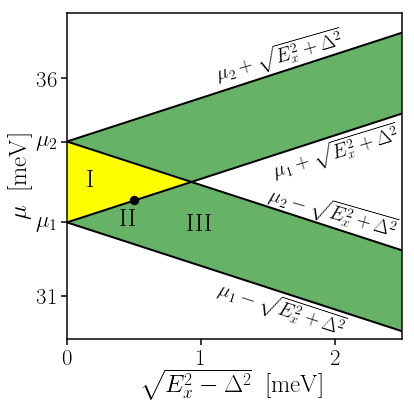

In [16]:
# mu1, mu2 = 1.83080333642, 1.84265848713

# continuum, [meV]
mu2=1000*0.0345459
mu1=1000*0.0326863

sqrts = np.linspace(0, 2.5, 401)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 1, 1)

# Boundaries, crossings with y axis
mu1p = mu1 + sqrts
mu1m = mu1 - sqrts
mu2p = mu2 + sqrts
mu2m = mu2 - sqrts

ax1.plot(sqrts, mu1p, 'k-', lw=2)
ax1.plot(sqrts, mu1m, 'k-', lw=2)
ax1.plot(sqrts, mu2p, 'k-', lw=2)
ax1.plot(sqrts, mu2m, 'k-', lw=2)

# set_ticks(ax, xticks, yticks)
ax1.set_yticks([31, mu1, mu2, 36]);
labels = [r'$31$', r'$\mu_1$', r'$\mu_2$', r'$36$']
ax1.set_yticklabels(labels);

ax1.tick_params(width=1.5, size=6, labelsize=23);

ax1.set_xlabel(r'$\sqrt{E_x^2 - \Delta^2}~~[\mathrm{meV}]$', size=25)
ax1.set_ylabel(r'$\mu ~~[\mathrm{meV}]$', fontsize=25)

ax1.fill_between(sqrts, mu1p, mu2p, where=(mu2p > mu1p), facecolor='green', alpha=0.6, interpolate=True)
ax1.fill_between(sqrts, mu1m, mu2m, where=(mu2m > mu1m), facecolor='green', alpha=0.6, interpolate=True)
ax1.fill_between(sqrts, mu2m, mu1p, where=(mu2m > mu1p), facecolor='yellow', interpolate=True)

# ax1.axhline(mu1, linestyle='dotted', color='black', lw=2)
# ax1.axhline(mu2, linestyle='dotted', color='black', lw=2)

ax1.text(0.15, 33.5, r'$\mathrm{I}$', fontsize=25)
ax1.text(0.4, 32.6, r'$\mathrm{II}$', fontsize=25)
plt.scatter(0.5, 33.2, color='black', s=70)
ax1.text(0.9, 32.5, r'$\mathrm{III}$', fontsize=25)

# ax1.text(0.5, 0.5, 'text 0', props, rotation=0)
ax1.text(1.1, 36.65, r'$\mu_2 + \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=16)
ax1.text(1.52, 34.45, r'$\mu_1 + \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=17)
ax1.text(1.48, 33.05, r'$\mu_2 - \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=-16)
ax1.text(1.1, 30.89, r'$\mu_1 - \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=-18)


# ax1.text(1, 1.835, r'$\romannumeral1$', fontsize=20)
# ax1.text(1, 1.835, r'$\textup{\uppercase\expandafter{\romannumeral 1}}$', fontsize=20)

ax1.set_ylim(30, 37.5);
ax1.set_xlim(sqrts[0], sqrts[-1])

plt.savefig('gap_closing_diagram.pdf', bbox_inches='tight')
# ax1.set_aspect('equal')

In [17]:
def nodal_circles_sketch(ax1, ax2, ax3):
    
    def coords(theta, r=1., shift=(0, 0)):
        return r*np.cos(theta) + shift[0], r*np.sin(theta) + shift[1]

    def nodal_points(angles, r=1., shift=(0, 0)):
        return zip(*[coords(angle, r=r, shift=shift) for angle in angles])
    
    def get_thetas(theta):
        # plus thetas, minus thetas
        return [theta, theta+2*np.pi/3, theta+4*np.pi/3], [-theta, -theta+2*np.pi/3, -theta+4*np.pi/3]
    
    # Circle radius
    r1 = 0.4
    r2 = 0.35

    ### Subfigure 1
    # Circle 1 nodal points
    theta1 = np.pi/12 + 0.05*np.pi
    plus_thetas, minus_thetas = get_thetas(theta1)
    pxs1, pys1 = nodal_points(plus_thetas, r=r1)
    mxs1, mys1 = nodal_points(minus_thetas, r=r1)

    # Circle 2 nodal points
    theta2 = np.pi/20
    plus_thetas, minus_thetas = get_thetas(theta2)
    mxs2, mys2 = nodal_points(plus_thetas, r=r2)
    pxs2, pys2 = nodal_points(minus_thetas, r=r2)

    # Nodal points
    point_size = 150
    ax1.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
    ax1.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
    ax1.scatter(pxs2, pys2, marker=r'P', color='b', s=point_size, zorder=4)
    ax1.scatter(mxs2, mys2, marker=r'*', color='r', s=point_size, zorder=4)

    # Lines projecting onto k_y
    y_coords = list(mys1) + list(pys1) + list(mys2) + list(pys2)
    x_coords = list(mxs1) + list(pxs1) + list(mxs2) + list(pxs2)
    eps = 0.0
    for y, x in zip(y_coords, x_coords):
        x_L = -1.1*r1
        x_R = x
        if any(np.isclose(y, list(mys1) + list(mys2))):
            ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
        else:
            ax1.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)

    # Boundaries of topological regions along y
    # Pairs of y-coordinates - topo between each pair.
    boundaries = list(zip(np.sort(list(mys1) + list(mys2)),
                          np.sort(list(pys1) + list(pys2))))
    delta = 0.01
    for boundary in boundaries:
        lower, upper = np.sort(boundary)
        ax1.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)

    # Circles where SOI vanishes
    circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs1, cys1 = zip(*circle1)
    ax1.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)
    circle2 = [coords(theta, r=r2) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs2, cys2 = zip(*circle2)
    ax1.plot(cxs2, cys2, linestyle='dotted', color='grey', lw=1.5, zorder=1)


    ### Subfigure 2
    # Circle 1 nodal points
    theta1 = np.pi/12 + 0.03*np.pi
    plus_thetas, minus_thetas = get_thetas(theta1)
    pxs1, pys1 = nodal_points(plus_thetas, r=r1)
    mxs1, mys1 = nodal_points(minus_thetas, r=r1)

    # Circle 2 nodal points
    theta2 = 0
    plus_thetas, minus_thetas = get_thetas(theta2)
    pxs2, pys2 = nodal_points(plus_thetas, r=r2)
    # mxs2, mys2 = nodal_points(minus_thetas, r=r2)

    # Nodal points
    ax2.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
    ax2.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
    ax2.scatter(pxs2, pys2, marker=r'D', color='m', s=point_size/2, zorder=4)

    # Lines projecting onto k_y
    y_coords = list(mys1) + list(pys1)
    x_coords = list(mxs1) + list(pxs1)
    eps = 0.0
    for y, x in zip(y_coords, x_coords):
        x_L = -1.1*r1
        x_R = x
        if any(np.isclose(y, mys1)):
            ax2.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
        else:
            ax2.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)

    # Boundaries of topological regions along y
    # Pairs of y-coordinates - topo between each pair.
    boundaries = list(zip(np.sort(mys1), np.sort(pys1)))
    delta = 0.01
    for boundary in boundaries:
        lower, upper = np.sort(boundary)
        ax2.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)


    # Circles where SOI vanishes
    circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs1, cys1 = zip(*circle1)
    ax2.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)
    circle2 = [coords(theta, r=r2) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs2, cys2 = zip(*circle2)
    ax2.plot(cxs2, cys2, linestyle='dotted', color='grey', lw=1.5, zorder=1)

    ### Subfigure 3
    # Circle 1 nodal points
    theta1 = np.pi/12 + 0.01*np.pi
    plus_thetas, minus_thetas = get_thetas(theta1)
    pxs1, pys1 = nodal_points(plus_thetas, r=r1)
    mxs1, mys1 = nodal_points(minus_thetas, r=r1)

    # Nodal points
    ax3.scatter(pxs1, pys1, marker=r'P', color='b', s=point_size, zorder=4)
    ax3.scatter(mxs1, mys1, marker=r'*', color='r', s=point_size, zorder=4)
    # Circles where SOI vanishes
    circle1 = [coords(theta, r=r1) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs1, cys1 = zip(*circle1)
    ax3.plot(cxs1, cys1, linestyle='dotted', color='grey', lw=1.5, zorder=1)

    # Lines projecting onto k_y
    y_coords = list(mys1) + list(pys1)
    x_coords = list(mxs1) + list(pxs1)
    eps = 0.0
    for y, x in zip(y_coords, x_coords):
        x_L = -1.1*r1
        x_R = x
        if any(np.isclose(y, mys1)):
            ax3.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='red', zorder=2)
        else:
            ax3.plot((x_L+eps, x_R-eps), (y, y), ls='dashed', lw=1.5, color='blue', zorder=2)

    # Boundaries of topological regions along y
    # Pairs of y-coordinates - topo between each pair.
    boundaries = list(zip(np.sort(mys1), np.sort(pys1)))
    delta = 0.01
    for boundary in boundaries:
        lower, upper = np.sort(boundary)
        ax3.plot([-1.1*r1, -1.1*r1], [lower+delta, upper-delta], color='g', lw=6, zorder=3)



    # k_x and k_y axes
    # k_y
    ax1.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax1.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
    ax2.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax2.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
    ax3.arrow(-1.1*r1, -r1*1.1, 0.0, r1*2.2, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax3.text(-1.1*r1+0.025, 1.07*r1, r'$k_y$', fontsize=25)
    # k_x
    ax1.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax1.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)
    ax2.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax2.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)
    ax3.arrow(-1.1*r1, -1.1*r1, 2.05*r1, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
    ax3.text(0.95*r1, -1.05*r1, r'$k_x$', fontsize=25)

    # K point
    ax1.scatter(0, 0, color='k', s=point_size/4, zorder=4)
    ax1.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)
    ax2.scatter(0, 0, color='k', s=point_size/4, zorder=4)
    ax2.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)
    ax3.scatter(0, 0, color='k', s=point_size/4, zorder=4)
    ax3.text(-0.09, -0.04, r'$\mathrm{K}$', fontsize=25)

    # Figure labels
    ax1.text(0.7*r1, 0.95*r1, r'$\mathrm{I}$', fontsize=25)
    ax2.text(0.7*r1, 0.95*r1, r'$\mathrm{II}$', fontsize=25)
    ax3.text(0.7*r1, 0.95*r1, r'$\mathrm{III}$', fontsize=25)

    ylim = (-1.2*r1, 1.3*r1)
    xlim = (-1.2*r1, 1.1*r1)
    ax1.set_ylim(ylim);
    ax2.set_ylim(ylim);
    ax3.set_ylim(ylim);
    ax1.set_xlim(xlim);
    ax2.set_xlim(xlim);
    ax3.set_xlim(xlim);

    ax1.set_aspect('equal')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.axis('off');

    ax2.set_aspect('equal')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.axis('off');

    ax3.set_aspect('equal')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.axis('off');

In [18]:
def make_hex_sheet(ax, x1, x2, y1, y2):
    norbs = [1, 1]
    MX2 = kwant.lattice.general([(1, 0), (-1/2, np.sqrt(3)/2)],  # Bravais lattice vectors a1 and a2
                                [(0, 0), (1/2, 1/(2*np.sqrt(3)))], # Atom coordinates in a unit cell, M and X
                                norbs=norbs) # Number of orbitals per atom type, M and X 
    M, X = MX2.sublattices
    

    def square(site):
        x, y = site.pos
        return (x1 <= x < x2) and (y1 <= y < y2)

    # Make a builder for a 2D system with a minimal unit cell.
    bulk_sym = kwant.TranslationalSymmetry(MX2.vec((1, 0)), MX2.vec((0, 1)))   # For 2D bulk trans inv
    bulk = kwant.Builder(bulk_sym)
    
    # Onsites
    bulk[[M(0, 0)]] = 1
    bulk[[X(0, 0)]] = 1
    
    bulk[MX2.neighbors()] = 1

    syst = kwant.Builder()
    added_sites = syst.fill(bulk, square,
                            (x1, y1), max_sites=float('inf'))
    
    def family_colors(site):
        # red, green, blue, transparency
        return 'black' if site.family != M else 'yellow'

    
    kwant.plot(syst, ax=ax, site_color=family_colors, site_size=0.20, site_lw=0.05, hop_lw=0.02,
               colorbar=False);
    ax.axis('off')
    ax.set_aspect('equal')
    
    ax.arrow(0.28, -0.18, 0.0, 1.1, head_width=0.08, head_length=0.1, fc='k',
              ec='k', zorder=1)
    ax.text(0.24, 1.15, r'$y$', fontsize=25)
    ax.arrow(0.28, -0.18, 1.1, 0.0, head_width=0.08, head_length=0.1,
              fc='k', ec='k', zorder=1)
    ax.text(1.55, -0.18, r'$x$', fontsize=25)
    
    ax.arrow(1.0, 1.73, 0.8, 0.0, width=0.02, head_width=0.15, head_length=0.2,
              fc='k', ec='k', zorder=2)
    ax.text(1.35, 1.47, r'${\bf a}_1$', fontsize=25)
    ax.arrow(1.0, 1.73, 0.4, 0.693, width=0.02, head_width=0.15, head_length=0.2,
              fc='k', ec='k', zorder=2)
    ax.text(0.95, 2.2, r'${\bf a}_2$', fontsize=25)
    
    ax.set_xlim(0.23, 2.75)
    ax.set_ylim(-0.22, 4)
    

In [19]:
def gap_closing_diagram(ax):
    # mu1, mu2 = 1.83080333642, 1.84265848713

    # continuum, [meV]
    mu2=1000*0.0345459
    mu1=1000*0.0326863

    sqrts = np.linspace(0, 2.5, 401)

    # Boundaries, crossings with y axis
    mu1p = mu1 + sqrts
    mu1m = mu1 - sqrts
    mu2p = mu2 + sqrts
    mu2m = mu2 - sqrts

    ax.plot(sqrts, mu1p, 'k-', lw=2)
    ax.plot(sqrts, mu1m, 'k-', lw=2)
    ax.plot(sqrts, mu2p, 'k-', lw=2)
    ax.plot(sqrts, mu2m, 'k-', lw=2)

    # set_ticks(ax, xticks, yticks)
    ax.set_yticks([31, mu1, mu2, 36]);
    labels = [r'$31$', r'$\mu_1$', r'$\mu_2$', r'$36$']
    ax.set_yticklabels(labels);

    ax.tick_params(width=1.5, size=6, labelsize=23);

    ax.set_xlabel(r'$\sqrt{E_x^2 - \Delta^2}~~[\mathrm{meV}]$', size=25)
    ax.set_ylabel(r'$\mu ~~[\mathrm{meV}]$', fontsize=25)

    ax.fill_between(sqrts, mu1p, mu2p, where=(mu2p > mu1p), facecolor='green', alpha=0.6, interpolate=True)
    ax.fill_between(sqrts, mu1m, mu2m, where=(mu2m > mu1m), facecolor='green', alpha=0.6, interpolate=True)
    ax.fill_between(sqrts, mu2m, mu1p, where=(mu2m > mu1p), facecolor='yellow', interpolate=True)

    # ax.axhline(mu1, linestyle='dotted', color='black', lw=2)
    # ax.axhline(mu2, linestyle='dotted', color='black', lw=2)

    ax.text(0.15, 33.5, r'$\mathrm{I}$', fontsize=25)
    ax.text(0.4, 32.6, r'$\mathrm{II}$', fontsize=25)
    plt.scatter(0.5, 33.2, color='black', s=70)
    ax.text(0.9, 32.5, r'$\mathrm{III}$', fontsize=25)

    # ax.text(0.5, 0.5, 'text 0', props, rotation=0)
    ax.text(1.1, 36.65, r'$\mu_2 + \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=16)
    ax.text(1.52, 34.45, r'$\mu_1 + \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=17)
    ax.text(1.48, 33.05, r'$\mu_2 - \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=-16)
    ax.text(1.1, 30.89, r'$\mu_1 - \sqrt{E_x^2 + \Delta^2}$', fontsize=20, rotation=-18)


    # ax.text(1, 1.835, r'$\romannumeral1$', fontsize=20)
    # ax.text(1, 1.835, r'$\textup{\uppercase\expandafter{\romannumeral 1}}$', fontsize=20)

    ax.set_ylim(30, 37.5);
    ax.set_xlim(sqrts[0], sqrts[-1])
    # ax.set_aspect('equal')

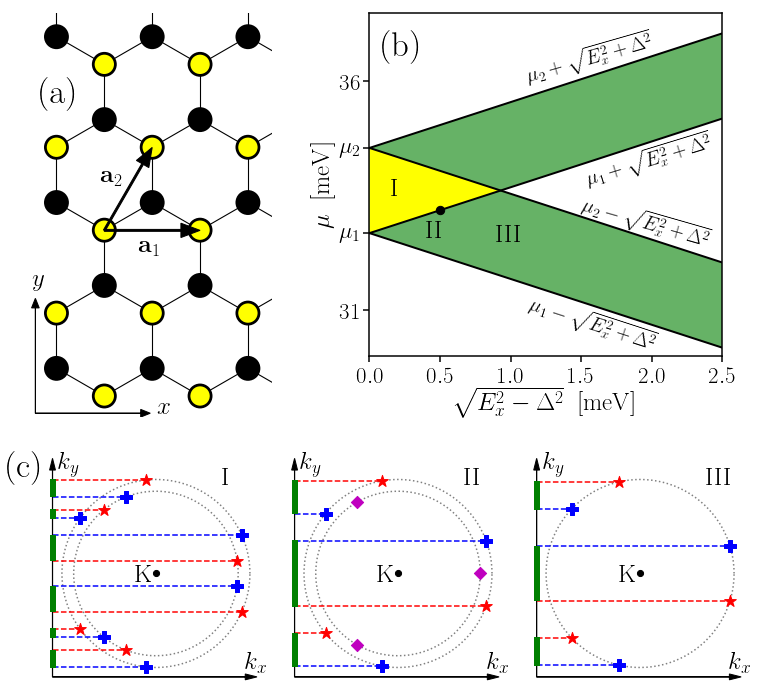

In [20]:
import matplotlib.gridspec as gridspec

fig = plt.figure()
fig.set_size_inches(13, 13)
gs = gridspec.GridSpec(150, 150)

# gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0:100, 0:50])
x1 = 0.4
x2 = 4
y1 = 0
y2 = 6
make_hex_sheet(ax1, x1, x2, y1, y2)

ax2 = plt.subplot(gs[7:80, 70:143])
gap_closing_diagram(ax2)

ax3 = plt.subplot(gs[100:, 0:50])
ax4 = plt.subplot(gs[100:, 50:100])
ax5 = plt.subplot(gs[100:, 100:150])
nodal_circles_sketch(ax3, ax4, ax5)

fig.text(0.135, 0.75, r'$\mathrm{(a)}$', fontsize=35)
fig.text(0.5, 0.8, r'$\mathrm{(b)}$', fontsize=35)
fig.text(0.1, 0.35, r'$\mathrm{(c)}$', fontsize=35)

plt.show()    

# Sketch nodal points different edge cut

In [21]:
0.5*Tpar.Kp[0]

2.0943951023931953

In [22]:
r = 1.6
shift = np.array([Tpar.Kp[0], 0])

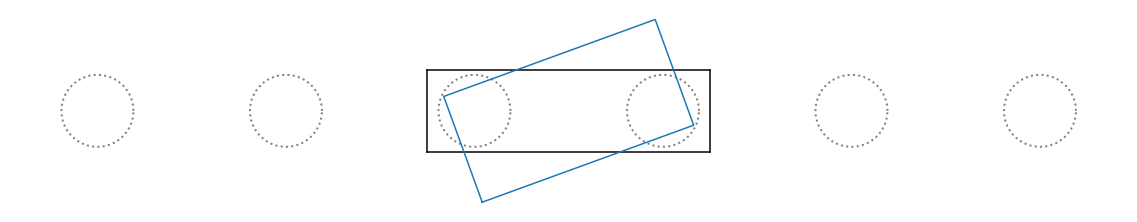

In [23]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 1, 1)

# Circles where SOI vanishes
circle = [coords(theta, r=r, shift=5*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=3*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-3*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-5*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)

# xbound = WxBZ/2 * 1.3 + r
# ax1.set_xlim(-xbound, xbound)
# ybound = WyBZ/2 * 1.3
# ax1.set_ylim(-ybound, ybound)

# # k_x and k_y axes
# ax1.arrow(0, -0.95*ybound, 0.0, 1.85*ybound, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
# ax1.text(0.025, 0.85*ybound, r'$k_y$', fontsize=25)
# ax1.arrow(-0.95*xbound, -0.9*ybound, 1.85*xbound, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
# ax1.text(0.85*xbound, -0.85*ybound, r'$k_x$', fontsize=25)

# BZ armchair unit cell
ax1.plot((-2*np.pi, 2*np.pi), (-np.pi/np.sqrt(3), -np.pi/np.sqrt(3)), color='black')
ax1.plot((-2*np.pi, 2*np.pi), (np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')
ax1.plot((-2*np.pi, -2*np.pi), (-np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')
ax1.plot((2*np.pi, 2*np.pi), (-np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')

length = 10
width = 5
angle = 20

def rotate_point(point, angle):
    angle = angle*2*np.pi/360
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]])
    return rot.dot(point)

corners = [np.array([-length/2, -width/2]),
           np.array([length/2, -width/2]),
           np.array([length/2, width/2]),
           np.array([-length/2, width/2])]
corners = [rotate_point(point, angle) for point in corners]
corners.append(corners[0])
xs, ys = zip(*corners)

plt.plot(xs, ys)

ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off');

# plt.savefig('nodal_BZ_sketch.pdf', bbox_inches='tight')

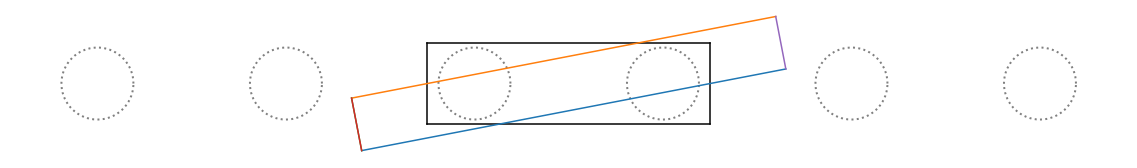

In [24]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 1, 1)

# Circles where SOI vanishes
circle = [coords(theta, r=r, shift=5*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=3*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-3*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
circle = [coords(theta, r=r, shift=-5*shift) for theta in np.linspace(0, 2*np.pi, 201)]
cxs, cys = zip(*circle)
plt.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)

# xbound = WxBZ/2 * 1.3 + r
# ax1.set_xlim(-xbound, xbound)
# ybound = WyBZ/2 * 1.3
# ax1.set_ylim(-ybound, ybound)

# # k_x and k_y axes
# ax1.arrow(0, -0.95*ybound, 0.0, 1.85*ybound, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
# ax1.text(0.025, 0.85*ybound, r'$k_y$', fontsize=25)
# ax1.arrow(-0.95*xbound, -0.9*ybound, 1.85*xbound, 0.0, head_width=0.025, head_length=0.05, fc='k', ec='k', zorder=1)
# ax1.text(0.85*xbound, -0.85*ybound, r'$k_x$', fontsize=25)

scale = 1

# BZ armchair unit cell
ax1.plot((-2*np.pi, 2*np.pi), (-np.pi/np.sqrt(3), -np.pi/np.sqrt(3)), color='black')
ax1.plot((-2*np.pi, 2*np.pi), (np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')
ax1.plot((-2*np.pi, -2*np.pi), (-np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')
ax1.plot((2*np.pi, 2*np.pi), (-np.pi/np.sqrt(3), np.pi/np.sqrt(3)), color='black')


# Another cut
m = 2
n = 3
# Same angle, but opposite twist
m = 1
n = 3

# Næs
# m = 2
# n = 5

# m = 2
# n = 5

kperp, kpar = func.k_BZ_edges(m, n)
kpar = kpar*scale
angle = func.angle_armchair(m, n)

ps = [np.array([-kperp, -kpar]), np.array([kperp, -kpar])]
ps = [func.tokxky(p, m, n) for p in ps]
xs = [p[0] for p in ps]
ys = [p[1] for p in ps]
ax1.plot(xs, ys)

ps = [np.array([-kperp, kpar]), np.array([kperp, kpar])]
ps = [func.tokxky(p, m, n) for p in ps]
xs = [p[0] for p in ps]
ys = [p[1] for p in ps]
ax1.plot(xs, ys)

ps = [np.array([-kperp, -kpar]), np.array([-kperp, kpar])]
ps = [func.tokxky(p, m, n) for p in ps]
xs = [p[0] for p in ps]
ys = [p[1] for p in ps]
ax1.plot(xs, ys)

ps = [np.array([-kperp, -kpar]), np.array([-kperp, kpar])]
ps = [func.tokxky(p, m, n) for p in ps]
xs = [p[0] for p in ps]
ys = [p[1] for p in ps]
ax1.plot(xs, ys)

ps = [np.array([kperp, -kpar]), np.array([kperp, kpar])]
ps = [func.tokxky(p, m, n) for p in ps]
xs = [p[0] for p in ps]
ys = [p[1] for p in ps]
ax1.plot(xs, ys)



ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off');

# plt.savefig('nodal_BZ_sketch.pdf', bbox_inches='tight')

In [25]:
# 4*np.pi/3
WxBZ = Tpar.Kp[0]

In [26]:
WxBZ*3

12.566370614359172

In [27]:
# (m, n) = (1, 2) í mínum grunni er armchair
# Gefur BZ: -2*pi < kx < 2*pi, -pi/sqrt(3) < ky < pi/sqrt(3)

In [28]:
Tpar.Kp

array([  4.18879020e+00,   2.96059473e-16])

In [29]:
m = 1
n = 3
func.k_BZ_edges(m, n)

(9.5977240918616058, 1.1874104117237259)

In [30]:
func.angle_armchair(1, 3)

10.893394649130901

In [31]:
func.angle_armchair(2, 3)

10.893394649130901

In [32]:
2*np.pi

6.283185307179586

In [33]:
np.pi/np.sqrt(3)

1.8137993642342178

In [34]:
r = 0.52
shift = np.array([1.2, 0])

In [292]:
def BZ_edge_cut_sketch(ax):
    r = 0.52
    shift = np.array([1.2, 0])

    # Circles where SOI vanishes
    circle = [coords(theta, r=r, shift=shift) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs, cys = zip(*circle)
    ax.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)
    circle = [coords(theta, r=r, shift=-shift) for theta in np.linspace(0, 2*np.pi, 201)]
    cxs, cys = zip(*circle)
    ax.plot(cxs, cys, linestyle='dotted', color='grey', lw=2, zorder=1)

    # Nodal points
    theta = 0.263*np.pi

    plus_thetas, minus_thetas = get_thetas(theta)
    pxsR, pysR = nodal_points(plus_thetas, r=r, shift=shift)
    mxsR, mysR = nodal_points(minus_thetas, r=r, shift=shift)
    pxsL, pysL = nodal_points([-theta + np.pi for theta in plus_thetas], r=r, shift=-shift)
    mxsL, mysL = nodal_points([-theta + np.pi for theta in minus_thetas], r=r, shift=-shift)
    ax.scatter(pxsR, pysR, marker=r'P', color='b', s=point_size, zorder=4)
    ax.scatter(mxsR, mysR, marker=r'*', color='r', s=point_size, zorder=4)
    ax.scatter(pxsL, pysL, marker=r'P', color='b', s=point_size, zorder=4)
    ax.scatter(mxsL, mysL, marker=r'*', color='r', s=point_size, zorder=4)

    # BZ armchair unit cell
    def rotate_point(point, angle):
        rot = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
        return rot.dot(point)

#     length = 4
#     width = 1.4
#     angle = 0
#     corners = [np.array([-length/2, -width/2]),
#                np.array([length/2, -width/2]),
#                np.array([length/2, width/2]),
#                np.array([-length/2, width/2])]
#     corners = [rotate_point(point, angle) for point in corners]
#     corners.append(corners[0])
#     xs, ys = zip(*corners)
#     ax.plot(xs, ys, color='black', linestyle='dashed')

    # Another cut
    length = 3.8
    width = 1.4
    angle = 5*2*np.pi/360
    corners = [np.array([-length/2, -width/2]),
               np.array([length/2, -width/2]),
               np.array([length/2, width/2]),
               np.array([-length/2, width/2])]
    corners = [rotate_point(point, angle) for point in corners]
    corners.append(corners[0])
    xs, ys = zip(*corners)
    ax.plot(xs, ys, color='black', linestyle='-.', linewidth=2)

    ### Projections of nodal points  ######
    def crossing_point(L1, L2):
        """Intersection point of two lines. L1 and L2 are tuples (slope, x, y), where
        x and y are points on the line. """
        h1, x1, y1 = L1
        h2, x2, y2 = L2
        xc = (h1*x1 - h2*x2 - y1 + y2)/(h1 - h2)
        yc = h1*xc - h1*x1 + y1
        return xc, yc

    # Nodal points by chirality
    p_points = list(zip(pxsR, pysR)) + list(zip(pxsL, pysL))
    m_points = list(zip(mxsR, mysR)) + list(zip(mxsL, mysL))
    # Edge of BZ line
    edge_line = (np.tan(angle + np.pi/2), *corners[0])

    p_crossings = [crossing_point((np.tan(angle), *p_point), edge_line) for p_point in p_points]
    for (x1, y1), (x2, y2) in zip(p_crossings, p_points):
        ax.plot([x1, x2], [y1, y2], color='blue', linestyle='dashed', zorder=2)
    m_crossings = [crossing_point((np.tan(angle), *m_point), edge_line) for m_point in m_points]
    for (x1, y1), (x2, y2) in zip(m_crossings, m_points):
        ax.plot([x1, x2], [y1, y2], color='red', linestyle='dashed', zorder=2)

    # Primitive BZ
    WxBZ = 2*shift[0]
    WyBZ = WxBZ * np.sqrt(3)/2
    BZ_corners = [(WxBZ/2, 0), (WxBZ/4, WyBZ/2), (-WxBZ/4, WyBZ/2),
                  (-WxBZ/2, 0), (-WxBZ/4, -WyBZ/2), (WxBZ/4, -WyBZ/2),
                 (WxBZ/2, 0)]
    corner_xs, corner_ys = zip(*BZ_corners)
    ax.plot(corner_xs, corner_ys, color='black', lw=4)

    # k_x and k_y axes
    ax.arrow(0, -0.6*WyBZ, 0.0, 1.15*WyBZ, head_width=0.075, head_length=0.1,
             linewidth=2, fc='k', ec='k', zorder=1)
    ax.text(0.075, 0.53*WyBZ, r'$k_y$', fontsize=30)
    ax.arrow(corners[0][0], corners[0][1], 2*np.abs(corners[0][0])+0.2, 0.0, linewidth=2,
             head_width=0.075, head_length=0.1,
             fc='k', ec='k', zorder=1)
    ax.text(0.81*WxBZ, -0.51*WyBZ, r'$k_x$', fontsize=30)
    
    # k_par and k_perp axes
    L = width + 0.2
    ax.arrow(corners[0][0], corners[0][1], L*np.cos(angle+np.pi/2), L*np.sin(angle+np.pi/2), linewidth=2,
             head_width=0.075, head_length=0.1, fc='k', ec='k', zorder=1)
    ax.text(-0.79*WxBZ, 0.33*WyBZ, r'$k_\parallel$', fontsize=30)
    L = length + 0.1
    ax.arrow(corners[0][0], corners[0][1], L*np.cos(angle), L*np.sin(angle), linewidth=2,
             head_width=0.075, head_length=0.1, fc='k', ec='k', zorder=1)
    ax.text(0.84*WxBZ, -0.22*WyBZ, r'$k_\perp$', fontsize=30)

    # Gamma, K, -K
    symmetry_points = [(0, 0), (WxBZ/2, 0), (-WxBZ/2, 0)]
    for point in symmetry_points:
        ax.scatter(point[0], point[1], color='k', s=point_size/3, zorder=4)
    ax.text(0.05, -0.11, r'$\Gamma$', fontsize=30)
    ax.text(WxBZ/2+0.05, -0.075, r'$\mathrm{K}$', fontsize=30)
    ax.text(-WxBZ/2-0.25, -0.075, r'-$\mathrm{K}$', fontsize=30, zorder=1)
    
    # Denote angle relative to armchair
    center = corners[0]
    r = 0.85*length
    angles = np.linspace(0, 0.087, 150)
    arc = [np.array(center) + np.array([r*np.cos(angle), r*np.sin(angle)]) for angle in angles]
    xs, ys = zip(*arc)
    plt.plot(xs, ys, color='black', linewidth=1)
    ax.text(0.6*WxBZ, -0.37*WyBZ, r'$\phi$', fontsize=30)

    # Topo regions on kpar axis
    sort_p_by_y = np.argsort(np.array([p_crossing[1] for p_crossing in p_crossings]))
    p_crossings = np.array(p_crossings)[sort_p_by_y]
    sort_m_by_y = np.argsort(np.array([m_crossing[1] for m_crossing in m_crossings]))
    m_crossings = np.array(m_crossings)[sort_m_by_y]
    delta = 0.015
    dx, dy = delta*np.cos(angle + np.pi/2), delta*np.sin(angle + np.pi/2)
    x0, y0 = p_crossings[0]
    x1, y1 = m_crossings[0]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    x0, y0 = p_crossings[1]
    x1, y1 = m_crossings[1]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    x0, y0 = m_crossings[2]
    x1, y1 = m_crossings[3]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    x0, y0 = m_crossings[3]
    x1, y1 = p_crossings[2]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='m', lw=6, zorder=3)
    x0, y0 = p_crossings[2]
    x1, y1 = p_crossings[3]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    x0, y0 = p_crossings[4]
    x1, y1 = m_crossings[4]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    x0, y0 = p_crossings[5]
    x1, y1 = m_crossings[5]
    ax.plot((x0+dx, x1-dx), (y0+dy, y1-dy), color='g', lw=6, zorder=3)
    
    # Winding number
    ax.text(-0.87*WxBZ, 0.05*WyBZ, r'$1$', fontsize=25)
    ax.arrow(-0.84*WxBZ, 0.08*WyBZ, 0.075, 0.22, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.arrow(-0.84*WxBZ, 0.07*WyBZ, 0.1, 0.01, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.arrow(-0.84*WxBZ, 0.06*WyBZ, 0.11, -0.18, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.text(-0.86*WxBZ, -0.11*WyBZ, r'$2$', fontsize=25)
    ax.arrow(-0.83*WxBZ, -0.09*WyBZ, 0.105, 0.01, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.text(-0.85*WxBZ, -0.26*WyBZ, r'$1$', fontsize=25)
    ax.arrow(-0.82*WxBZ, -0.23*WyBZ, 0.075, 0.2, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.arrow(-0.82*WxBZ, -0.24*WyBZ, 0.1, 0.01, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    ax.arrow(-0.82*WxBZ, -0.25*WyBZ, 0.12, -0.2, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=6)
    
    ax.set_ylim(-0.53*WyBZ, 0.6*WyBZ)
    ax.set_xlim(-0.85*WxBZ, 0.9*WxBZ)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off');

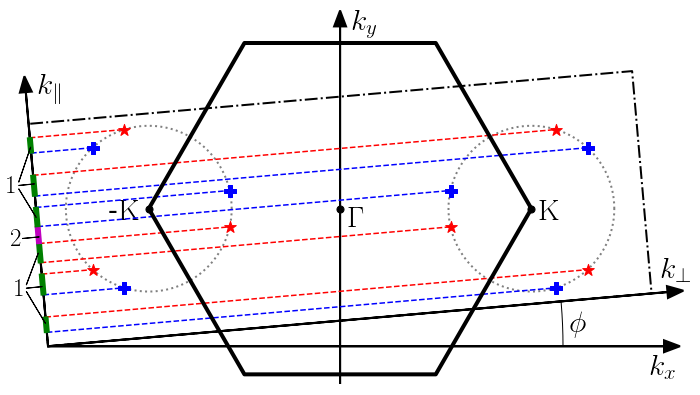

In [293]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
test(ax)